# Solar Irradiance

## Data Description

These datasets are meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

For each dataset, the fields are:

A row number (1-n) useful in sorting this export's results The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results The date in yyyy-mm-dd format The local time of day in hh:mm:ss 24-hour format The numeric data, if any (may be an empty string) The text data, if any (may be an empty string)

The units of each dataset are:

*    Solar radiation: watts per meter^2
 
*    Temperature: degrees Fahrenheit

*    Humidity: percent

*    Barometric pressure: Hg

*    Wind direction: degrees

*    Wind speed: miles per hour

*    Sunrise/sunset: Hawaii time

Link: https://www.kaggle.com/datasets/dronio/SolarEnergy

## Table of Contents

1.  Importing Libraries
2. Loading Data
3. Data Wrangling
4. Feature Selection using Correlation Matrix
5. Feature Selection using SelectKBest Method
6. Feature Selection using Extra Tree Classifier
7. Feature Engineering with BoxCox, Log, Min-Max and Standard transformation
8. Preparing data - Standardisation and Splitting
9. Prediction with XGBoost
10. Using MultiLayer Perceptron for prediction

## Importing Libraries

In [1]:
#Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Stats
from scipy import stats

#For regex search
import re

#ML
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.feature_selection import SelectKBest , chi2
from sklearn.model_selection import train_test_split

import xgboost as xbg

#For building CNN and layers
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.optimizers import SGD , Adam
from tensorflow.keras.models import Sequential

#Metrics
from sklearn.metrics import mean_squared_error,median_absolute_error,r2_score

#Time
import datetime as dt

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# data = pd.read_csv('SolarPrediction.csv')
url ='https://raw.githubusercontent.com/aditya-somani/datasets/refs/heads/main/SolarPrediction.csv'
data = pd.read_csv(url)
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


## Data Wrangling

In [4]:
df = data.copy()
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [5]:
'9/29/2016 12:00:00 AM'.split()

['9/29/2016', '12:00:00', 'AM']

In [6]:
df['Data'] = df['Data'].apply(lambda x:x.split()[0])
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [7]:
type(df['Data'].iloc[0])

str

In [8]:
pd.to_datetime(df['Data'].iloc[0:5]).dt.month

0    9
1    9
2    9
3    9
4    9
Name: Data, dtype: int32

In [9]:
#Need to convert it into date time and extract the month
df['Month'] = pd.to_datetime(df['Data']).dt.month
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9


In [10]:
df.tail()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month
32681,1480587604,12/1/2016,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00,12
32682,1480587301,12/1/2016,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00,12
32683,1480587001,12/1/2016,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00,12
32684,1480586702,12/1/2016,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00,12
32685,1480586402,12/1/2016,00:00:02,1.20,44,30.43,101,83.59,3.37,06:41:00,17:42:00,12


Therefore , we successfully extracted Month , now repeat this process for day , hour , min and seconds

In [11]:
df['Day'] = pd.to_datetime(df['Data']).dt.day

df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second

df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24


Doing the Same for SunRise and SunSet but now using the regex!

To know that a alternative method exist

In [12]:
re.search('^\d+','06:13:00').group(0)

'06'

In [13]:
re.search('\d+','06:13:00')

<re.Match object; span=(0, 2), match='06'>

In [14]:
df['riseHour'] = df['TimeSunRise'].apply(lambda x:re.search('^\d+',x).group(0)).astype(int)
df['riseMin'] = df['TimeSunRise'].apply(lambda x:re.search('(?<=:)\d+(?=:)',x).group(0)).astype(int)

df['setHour'] = df['TimeSunSet'].apply(lambda x:re.search('^\d+',x).group(0)).astype(int)
df['setMin'] = df['TimeSunSet'].apply(lambda x:re.search('(?<=:)\d+(?=:)',x).group(0)).astype(int)

df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,riseHour,riseMin,setHour,setMin
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
 11  Month                   32686 non-null  int32  
 12  Day                     32686 non-null  int32  
 13  Hour                    32686 non-null  int32  
 14  Minute                  32686 non-null

In [16]:
df=df.drop(['UNIXTime','Data','Time','TimeSunSet','TimeSunRise'],axis=1)

In [17]:
df.shape

(32686, 15)

In [18]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,riseHour,riseMin,setHour,setMin
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [19]:
df.isna().sum().sum()

0

In [20]:
x = df.drop(['Radiation'],axis=1)
y = df['Radiation']

## Feature selection using Correlation

In [21]:
corr_mat = df.corr()
corr_mat

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,riseHour,riseMin,setHour,setMin
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


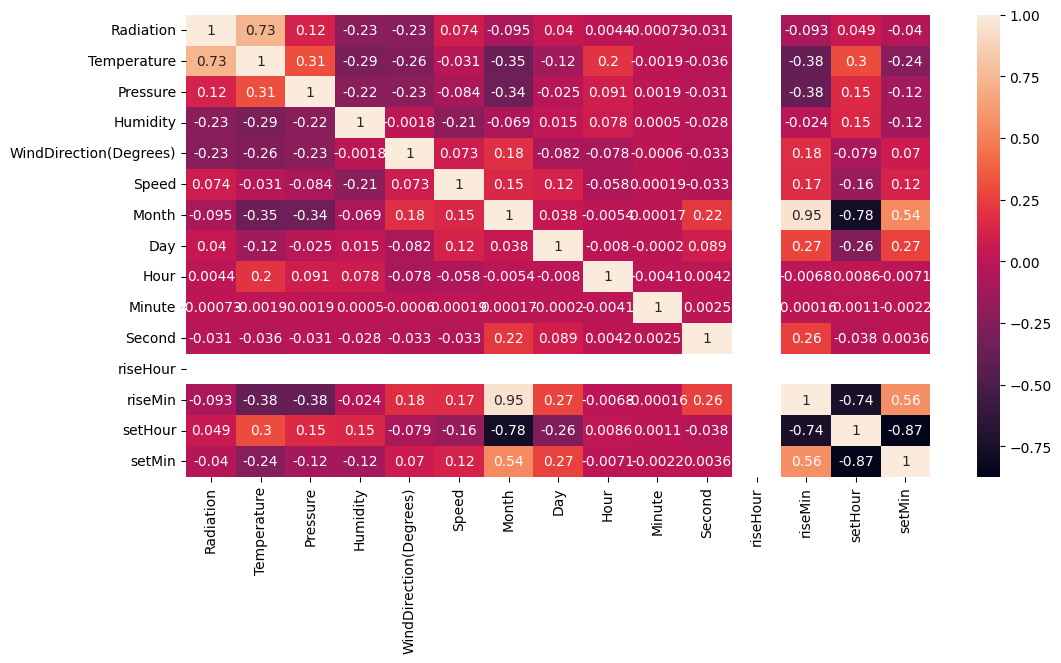

In [22]:
plt.figure(figsize=(12,6))
sns.heatmap(corr_mat,annot=True)
plt.show()

## Feature selection using SelectKBest Method

The SelectKBest method in machine learning is a feature selection technique used to select the top 
K features from the dataset based on statistical tests.

In [23]:
bestfeatures = SelectKBest(score_func=chi2,k=10)

In [24]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
ytrain = labelencoder.fit_transform(y)

In [25]:
ytrain[:5],y.iloc[:5] #Earlier it was in float 

#We could also simply multiply by hundred to get the integer value

(array([ 9,  9, 11,  9,  5]),
 0    1.21
 1    1.21
 2    1.23
 3    1.21
 4    1.17
 Name: Radiation, dtype: float64)

In [26]:
#Now before fitting the data , we need to scale it
scaledInput = MinMaxScaler().fit_transform(x)
fit = bestfeatures.fit(scaledInput,ytrain)

In [27]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(x.columns)
feat_scores = pd.concat([column,scores],axis=1)
feat_scores.columns=['Feature','Feature_imp']
feat_scores 

,Feature,Feature_imp
0,Temperature,1655.516161
1,Pressure,527.712095
2,Humidity,1600.068787
3,WindDirection(Degrees),3294.026554
4,Speed,771.727960
5,Month,4721.289935
6,Day,2862.204099
7,Hour,702.794931
8,Minute,2728.507341
9,Second,2312.419224


In [28]:
feat_scores = feat_scores.sort_values(by = 'Feature_imp',ascending=False)

In [29]:
feat_scores

,Feature,Feature_imp
12,setHour,12289.463887
5,Month,4721.289935
11,riseMin,4044.452710
3,WindDirection(Degrees),3294.026554
6,Day,2862.204099
8,Minute,2728.507341
9,Second,2312.419224
13,setMin,1877.276484
0,Temperature,1655.516161
2,Humidity,1600.068787


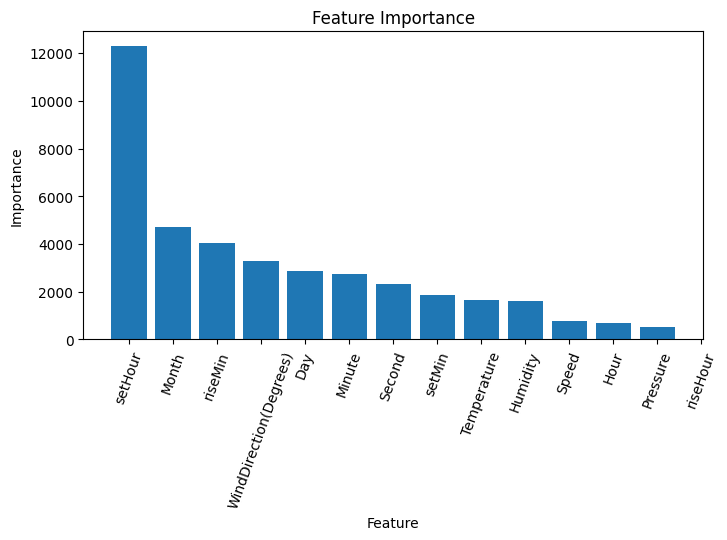

In [30]:
plt.figure(figsize=(8,4))
plt.bar(feat_scores.Feature,feat_scores.Feature_imp)
plt.xticks(rotation = 70)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

## Feature Selection ExtraTreeClassifier

In [31]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(n_estimators=3,verbose=2)
model.fit(scaledInput,ytrain)

building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


ExtraTreesClassifier(n_estimators=3, verbose=2)

In [32]:
feat = pd.DataFrame(model.feature_importances_,index = feat_scores.Feature,columns = ['Feat'])
feat.sort_values(by='Feat',ascending=False,inplace=True)
feat

,Feat
Feature,
WindDirection(Degrees),0.159550
Temperature,0.149648
Day,0.128636
Humidity,0.124539
riseMin,0.109587
setMin,0.086416
setHour,0.081657
Month,0.076301
Second,0.033512


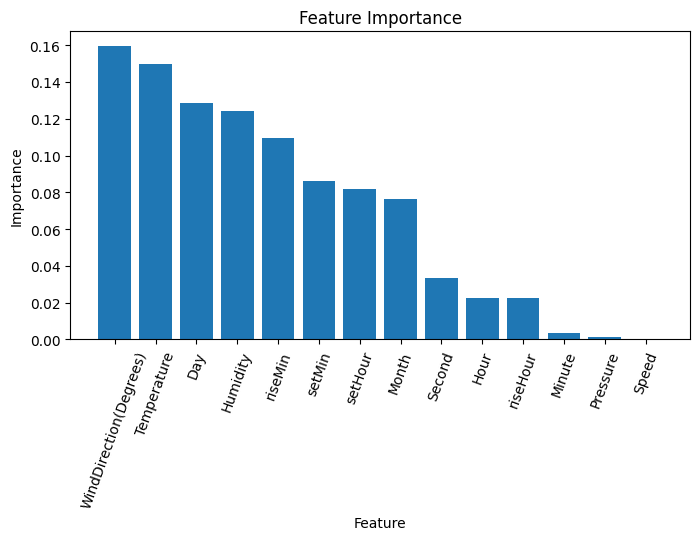

In [33]:
plt.figure(figsize=(8,4))
plt.bar(feat.index,feat.Feat)
plt.xticks(rotation = 70)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

So , Its now clear that all these different models are giving different different imp and priority , So let's try some different stuff now!

## Feature Engineering with BoxCox , Log , Min-Max and Standard transformation

In [34]:
scaledInput

array([[0.37837838, 0.72972973, 0.53684211, ..., 0.12      , 1.        ,
        0.22033898],
       [0.37837838, 0.72972973, 0.52631579, ..., 0.12      , 1.        ,
        0.22033898],
       [0.37837838, 0.72972973, 0.51578947, ..., 0.12      , 1.        ,
        0.22033898],
       ...,
       [0.27027027, 0.62162162, 0.98947368, ..., 0.68      , 0.        ,
        0.71186441],
       [0.27027027, 0.62162162, 0.97894737, ..., 0.68      , 0.        ,
        0.71186441],
       [0.27027027, 0.64864865, 0.97894737, ..., 0.68      , 0.        ,
        0.71186441]])

In [35]:
feat_to_transform = list(x.columns)[:5]
feat_to_transform

['Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']

**Normal Histogram**

<Axes: >

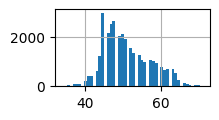

In [36]:
plt.figure(figsize=(2,1))
x['Temperature'].hist(bins=50)

array([[<Axes: title={'center': 'Temperature'}>]], dtype=object)

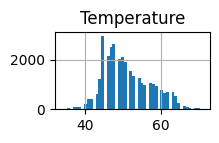

In [37]:
pd.DataFrame(x['Temperature']).hist(bins=50,figsize=(2,1)) #convert it to dataframe in cas ethere are more than one columns!

**Log Histogram**

<Axes: >

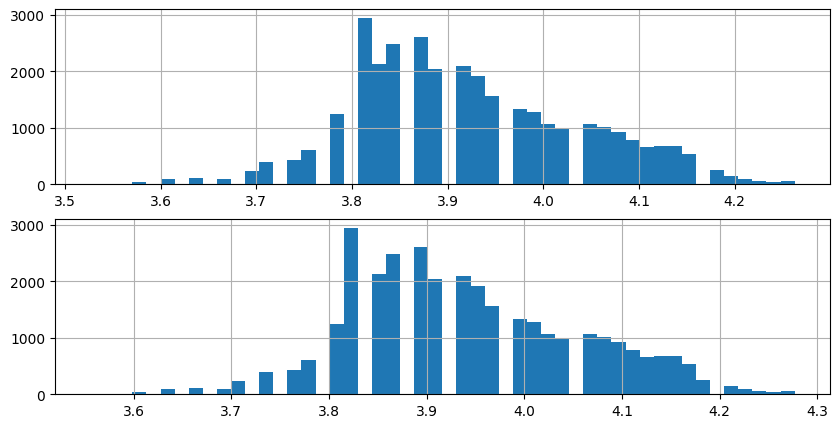

In [38]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize = (10,5))
x['Temperature'].transform(np.log).hist(ax=ax1,bins=50)
((x['Temperature']+1).transform(np.log)).hist(ax=ax2,bins=50) #To tackle the zero values

**BoxCox Histogram**

In [39]:
len(stats.boxcox(x['Temperature']+1)),stats.boxcox(x['Temperature']+1)

(2,
 (array([1.05910804, 1.05910804, 1.05910804, ..., 1.0566174 , 1.0566174 ,
         1.0566174 ]), -0.9176405677065019))

array([[<Axes: title={'center': '0'}>]], dtype=object)

<Figure size 200x100 with 0 Axes>

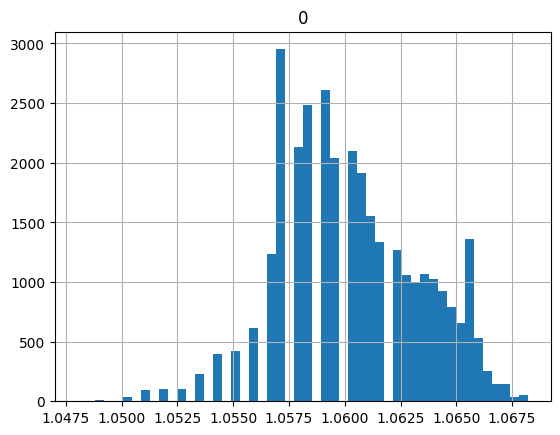

In [40]:
plt.figure(figsize = (2,1))
pd.DataFrame(stats.boxcox(x['Temperature']+1)[0]).hist(bins=50)

**Standard Scaler Histogram**

array([[<Axes: title={'center': '0'}>]], dtype=object)

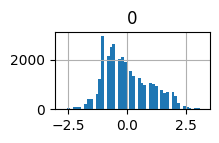

In [41]:
# pd.DataFrame(StandardScaler().fit_transform(pd.DataFrame(x['Temperature']))).hist(bins=50)
# or
pd.DataFrame(StandardScaler().fit_transform(np.array(x['Temperature']).reshape(-1,1))).hist(bins=50,figsize = (2,1))

Min-Max Scaler

array([[<Axes: title={'center': '0'}>]], dtype=object)

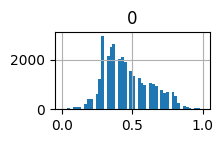

In [42]:
pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame(x['Temperature']))).hist(bins=50,figsize=(2,1))

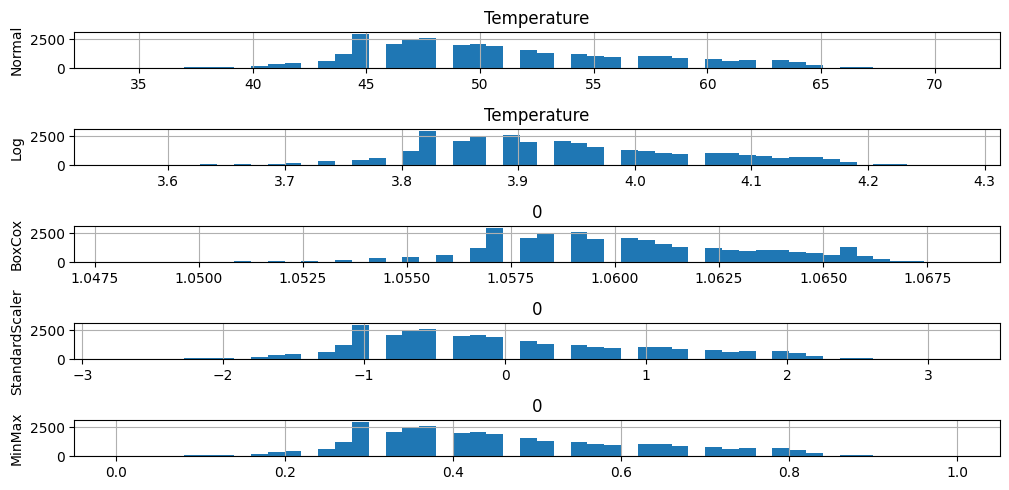

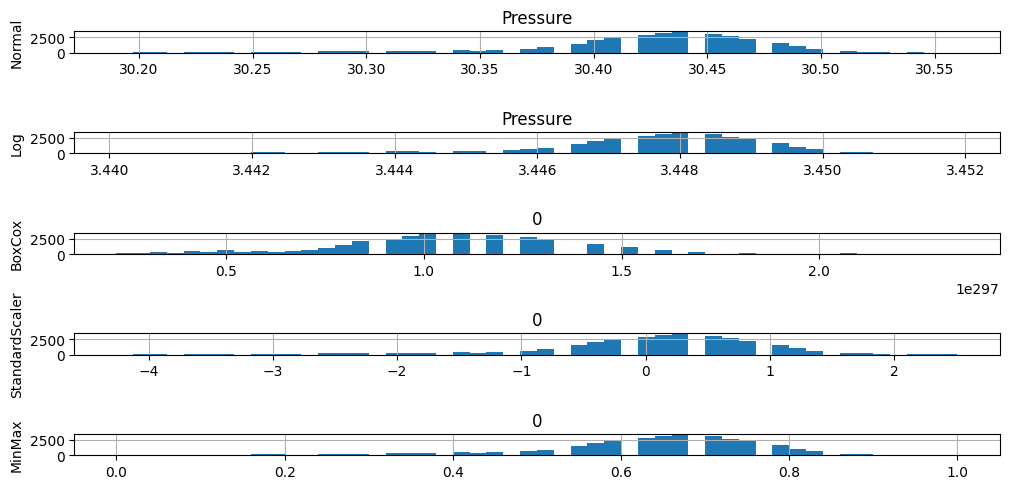

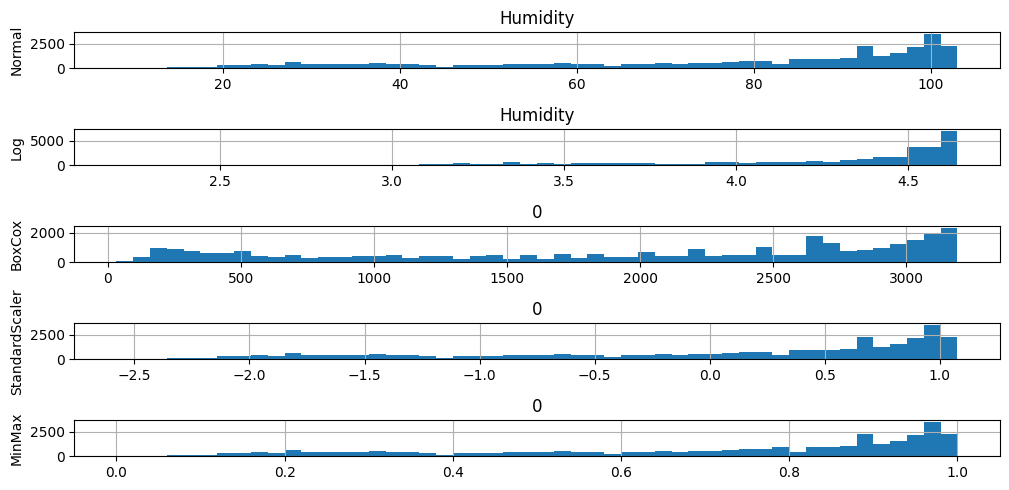

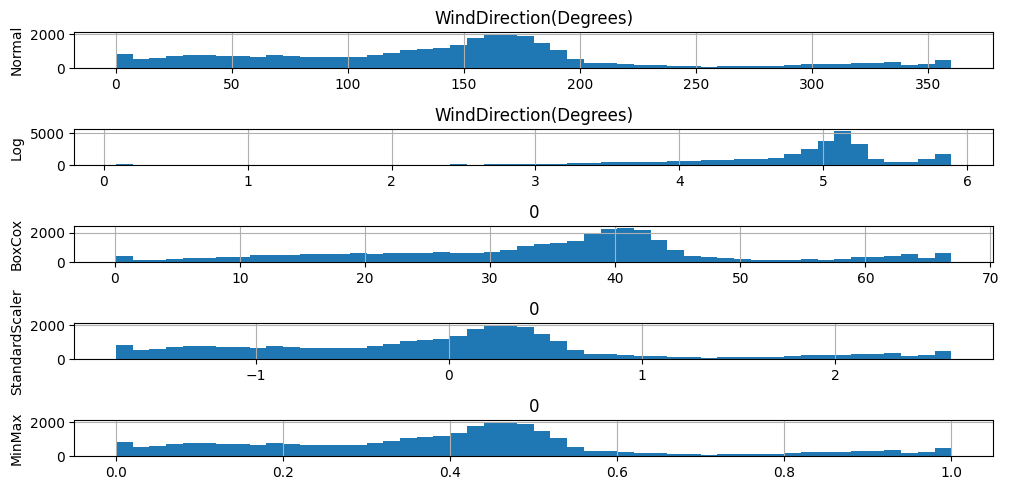

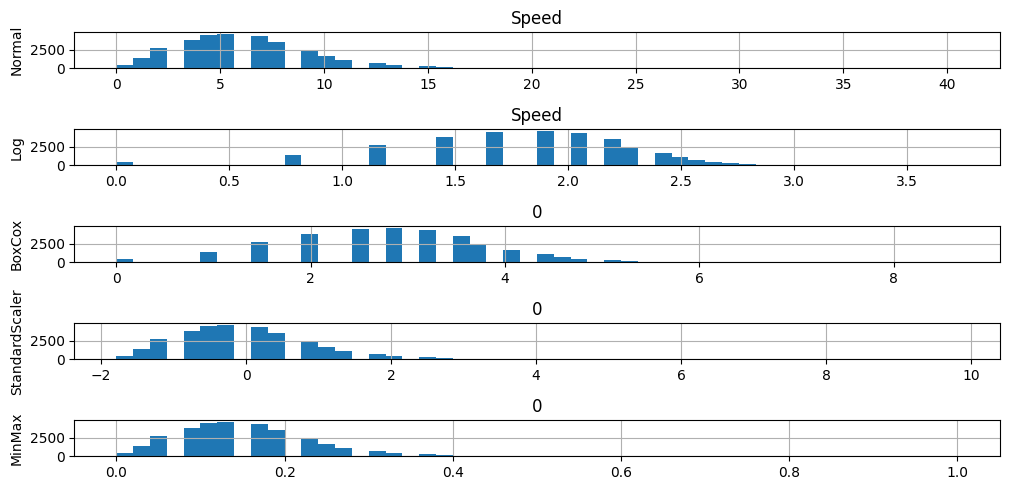

In [43]:
feat_to_transform = list(x.columns)[:5]
for i in feat_to_transform:

    fig , (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(10,5))

    pd.DataFrame(x[i]).hist(ax=ax1,bins=50)
    pd.DataFrame((x[i]+1).transform(np.log)).hist(ax=ax2,bins=50)
    pd.DataFrame(stats.boxcox(x[i]+1)[0]).hist(ax=ax3,bins=50)
    pd.DataFrame(StandardScaler().fit_transform(np.array(x[i]).reshape(-1,1))).hist(bins=50,ax=ax4)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(x[i]).reshape(-1,1))).hist(bins=50,ax=ax5)

    plt.tight_layout()

    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('BoxCox')
    ax4.set_ylabel('StandardScaler')
    ax5.set_ylabel('MinMax')
    

**Selecting the best possible Transformation which mimicks Normal Distribution and Replacing it in data**

Though Why are we taking Normal Distribution , because the normal distribution explains the practical scenario the best

In [44]:
x.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,riseHour,riseMin,setHour,setMin
0,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [45]:
transform = {
    'Temperature' : (x['Temperature']+1).transform(np.log),
    'Pressure' : stats.boxcox(x['Pressure']+1)[0],
    'Humidity' : stats.boxcox(x['Humidity']+1)[0],
    'WindDirection(Degrees)' : MinMaxScaler().fit_transform(np.array(x['WindDirection(Degrees)']).reshape(-1,1)),
    'Speed' : (x['Speed']+1).transform(np.log)
}

for i in transform:
    x[i] = transform[i]
x.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,riseHour,riseMin,setHour,setMin
0,3.89182,1.245832e+297,1139.358153,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,1.245832e+297,1104.046486,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,1.245832e+297,1069.253069,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,1.245832e+297,1175.186958,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,1.245832e+297,1248.391644,0.291391,1.890095,9,29,23,35,24,6,13,18,13


## Preparing Data - Standardisation and Splitting

In [46]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=1)
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [47]:
xtrain.shape,xtest.shape

((26148, 14), (6538, 14))

In [48]:
from xgboost import XGBRegressor

para ={
    'learning_rate':0.1,
    'max_depth':8 
}

model = XGBRegressor(**para)

In [49]:
model.fit(xtrain,ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [50]:
ypred = model.predict(xtest)

In [51]:
rmse = np.sqrt(mean_squared_error(ytest,ypred))
r2 = r2_score(ytest,ypred)

print(f'RMSE : {rmse}')
print(f'R2 : {r2}')

RMSE : 82.99447188040851
R2 : 0.929286892835236


## Using MultiLayer Perceptron for Prediction

In [52]:
x.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,riseHour,riseMin,setHour,setMin
0,3.89182,1.245832e+297,1139.358153,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,1.245832e+297,1104.046486,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,1.245832e+297,1069.253069,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,1.245832e+297,1175.186958,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,1.245832e+297,1248.391644,0.291391,1.890095,9,29,23,35,24,6,13,18,13


In [53]:
y.head()

0    1.21
1    1.21
2    1.23
3    1.21
4    1.17
Name: Radiation, dtype: float64

In [66]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature             32686 non-null  float64
 1   Pressure                32686 non-null  float64
 2   Humidity                32686 non-null  float64
 3   WindDirection(Degrees)  32686 non-null  float64
 4   Speed                   32686 non-null  float64
 5   Month                   32686 non-null  int32  
 6   Day                     32686 non-null  int32  
 7   Hour                    32686 non-null  int32  
 8   Minute                  32686 non-null  int32  
 9   Second                  32686 non-null  int32  
 10  riseHour                32686 non-null  int64  
 11  riseMin                 32686 non-null  int64  
 12  setHour                 32686 non-null  int64  
 13  setMin                  32686 non-null  int64  
dtypes: float64(5), int32(5), int64(4)
memo

In [69]:
xtrain[:1]

array([[ 1.40350795,         nan, -0.33356017, -1.71988079, -0.30452565,
        -1.39801222,  1.27923063, -0.22385698,  0.72408533,  0.2725994 ,
         0.        , -0.9492458 ,  1.3799874 , -1.41000176]])

After carefull observation , I came to know that using StandardScaler on my data I am getting "NaN" in my pressure column this is because the values of pressure is very very large so standarizing them by diving with std. dev which is very small compared to values of pressure will result in overflow , hence it is giving error.

In [70]:
print(x['Pressure'].describe())  # Summary statistics of the column

count     3.268600e+04
mean     1.037349e+297
std                inf
min      2.224229e+296
25%      8.506123e+296
50%      1.029521e+297
75%      1.245832e+297
max      2.349480e+297
Name: Pressure, dtype: float64


In [71]:
x['Pressure'] = x['Pressure'] / 1e297  # Scale down by dividing by the maximum exponent
x['Pressure'].sample(n=5)

32660    0.966072
20739    1.097115
23225    1.327548
3629     1.169123
5060     0.966072
Name: Pressure, dtype: float64

In [72]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [55]:
# from sklearn.impute import SimpleImputer

# imputer = SimpleImputer(strategy='mean')  # Choose strategy: 'mean', 'median', or 'most_frequent'
# xtrain = imputer.fit_transform(xtrain)


In [73]:
xtrain.shape

(26148, 14)

In [74]:
xtrain[:1]

array([[ 1.40350795, -0.42264845, -0.33356017, -1.71988079, -0.30452565,
        -1.39801222,  1.27923063, -0.22385698,  0.72408533,  0.2725994 ,
         0.        , -0.9492458 ,  1.3799874 , -1.41000176]])

In [75]:
model = None
model = Sequential()

model.add(Dense(128,activation='relu',input_dim=14))
model.add(Dropout(0.33))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1,activation='linear'))

model.compile(metrics=['mse'],loss='mae',optimizer = Adam(learning_rate=0.001))
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [76]:
history = model.fit(xtrain,ytrain,validation_split=0.1,epochs=50,batch_size=32)

Epoch 1/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 162.5446 - mse: 94160.7656 - val_loss: 77.9936 - val_mse: 22847.1992
Epoch 2/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 86.8999 - mse: 28492.3203 - val_loss: 69.5959 - val_mse: 18470.0371
Epoch 3/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 81.6593 - mse: 25250.2012 - val_loss: 65.2747 - val_mse: 16660.7617
Epoch 4/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 79.2792 - mse: 24029.1582 - val_loss: 65.3349 - val_mse: 16763.2090
Epoch 5/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 75.7096 - mse: 22442.9062 - val_loss: 60.5744 - val_mse: 14510.7090
Epoch 6/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 72.4002 - mse: 20633.4688 - val_loss: 60.5072 - val_mse: 14747.8359
Epoch 7/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 74.7116 - mse: 21769.0586 - val_loss: 56.7756 - val_mse: 13409.2939
Epoch 8/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 71.7017 - mse: 19879.3926 - val_loss: 53.90

In [77]:
history.history

{'loss': [123.40351867675781,
  86.69898986816406,
  81.59422302246094,
  79.19669342041016,
  76.21793365478516,
  74.55288696289062,
  73.10848999023438,
  71.73892211914062,
  70.41700744628906,
  69.30624389648438,
  69.01683044433594,
  68.11626434326172,
  67.84571075439453,
  66.85607147216797,
  66.8898696899414,
  66.55361938476562,
  65.43480682373047,
  65.21649169921875,
  65.37163543701172,
  64.94316864013672,
  65.57207489013672,
  65.6828384399414,
  65.28099060058594,
  64.43634796142578,
  63.498836517333984,
  63.457000732421875,
  63.10284423828125,
  63.65858459472656,
  62.745277404785156,
  62.43016815185547,
  63.079017639160156,
  62.19929504394531,
  62.6535758972168,
  62.74817657470703,
  62.02864456176758,
  62.12312316894531,
  61.58045959472656,
  61.34757614135742,
  60.97871780395508,
  60.86985778808594,
  60.35358428955078,
  61.16722106933594,
  61.633583068847656,
  60.69590759277344,
  61.31503677368164,
  60.835205078125,
  59.53396987915039,
  60

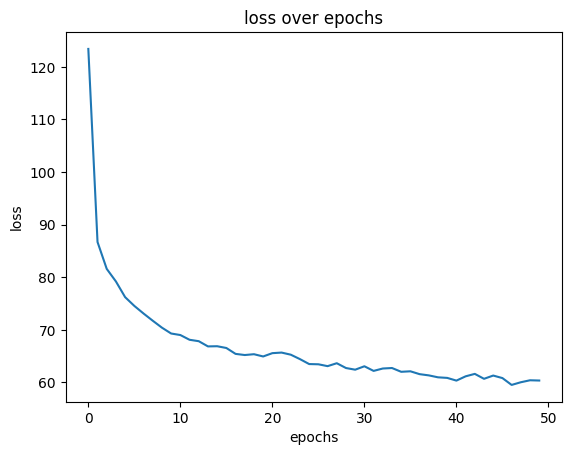

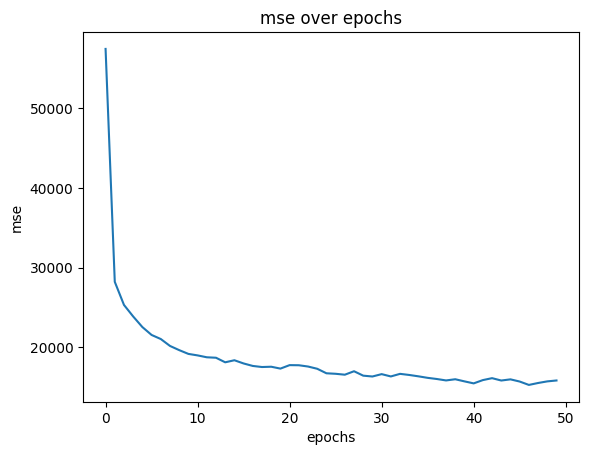

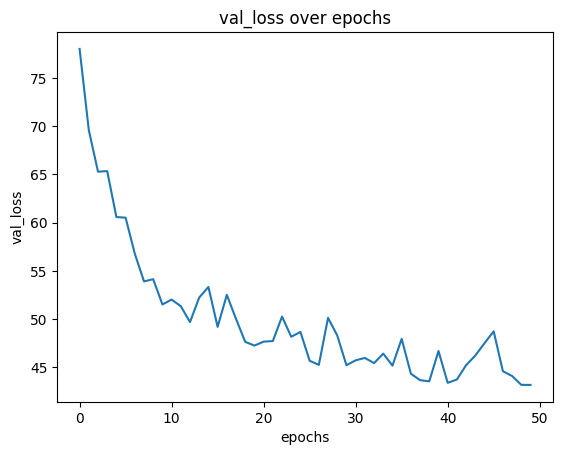

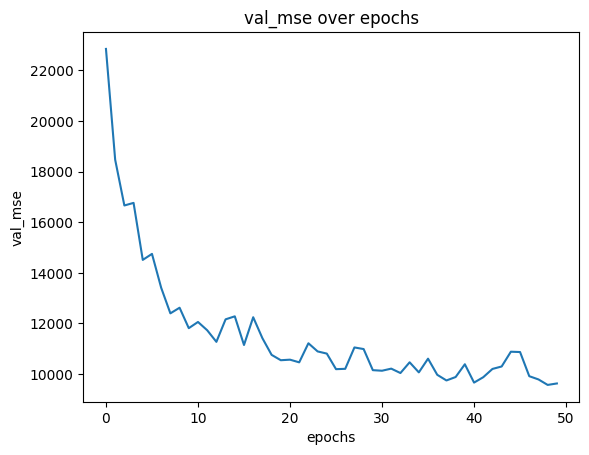

In [79]:
fit = history.history

for i in fit:
    plt.plot(fit[i])
    plt.title(i + ' over epochs')
    plt.xlabel('epochs')
    plt.ylabel(i)
    plt.show()


In [80]:
ypred = model.predict(xtest)

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [82]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ytest,ypred)

41.82800530030407